<a href="https://colab.research.google.com/github/kw01sg/neural-style-transfer/blob/master/google_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone and Install Dependencies

In [0]:
!git clone https://github.com/kw01sg/neural-style-transfer.git

Cloning into 'neural-style-transfer'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 121 (delta 60), reused 76 (delta 32), pack-reused 0
Receiving objects: 100% (121/121), 9.24 MiB | 1.19 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [0]:
%cd neural-style-transfer

/content/neural-style-transfer


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 34kB/s 
     |████████████████████████████████| 3.1MB 51.1MB/s 
     |████████████████████████████████| 501kB 45.9MB/s 


## Demo

In [0]:
!python neural_transfer.py --help

usage: neural_transfer.py [-h] [-c CONTENT_PATH] [-s STYLE_PATH]
                          [-cw CONTENT_WEIGHT] [-sw STYLE_WEIGHT]
                          [-vw VARIATION_WEIGHT] [-lr LEARNING_RATE]
                          [-e EPOCHS] [-steps STEPS_PER_EPOCH]
                          [-o OUTPUT_FILE]

Perform neural style transfer.

optional arguments:
  -h, --help            show this help message and exit
  -c CONTENT_PATH, --content-path CONTENT_PATH
                        path of content image
  -s STYLE_PATH, --style-path STYLE_PATH
                        path of style image
  -cw CONTENT_WEIGHT, --content-weight CONTENT_WEIGHT
                        content weight
  -sw STYLE_WEIGHT, --style-weight STYLE_WEIGHT
                        style weight
  -vw VARIATION_WEIGHT, --variation-weight VARIATION_WEIGHT
                        variation weight
  -lr LEARNING_RATE, --learning-rate LEARNING_RATE
                        learning rate for Adam optimizer
  -e EPOCHS, --epoch

In [0]:
!python neural_transfer.py

Running neural style transfer with the following parameters:

	content_path: data/demo/chicago.jpg
	style_path: data/demo/candy.jpg
	content_weight: 0.4
	style_weight: 1.0
	variation_weight: 20000.0
	learning_rate: 10.0
	epochs: 10
	steps_per_epoch: 100
	output_file: result.png

574717952/574710816 [==============================] - 42s 0us/step
W0628 15:09:30.165797 139681144563584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
100/100 [==================================================] - 15s - 147ms/step
Epoch 2/10
100/100 [==================================================] - 13s - 132ms/step
Epoch 3/10
100/100 [==================================================] - 13s - 132ms/step
Epoch 4/10

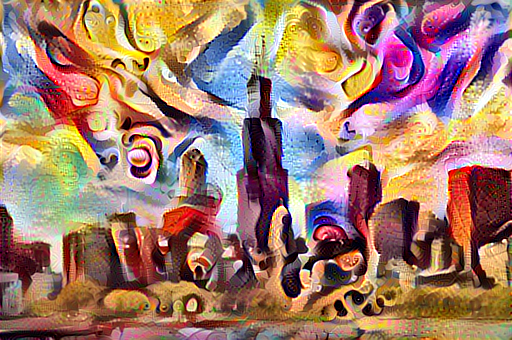

In [0]:
from PIL import Image

Image.open('/content/neural-style-transfer/data/results/result.png')

## Hands On

In [0]:
from google.colab import files

In [0]:
# upload your content image file
files.upload()

In [0]:
# upload your style image file
files.upload()

In [0]:
!python neural_transfer.py -c {path to content image} -s {path to style image}

In [0]:
from PIL import Image

Image.open('/content/neural-style-transfer/data/results/result.png')